<a href="https://www.kaggle.com/code/sanghyuni/kickboard?scriptVersionId=160647740" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d/sanghyuni/seoul-public-kickboard-towing-data-and-parking-data/App_parking.xlsx
/kaggle/input/d/sanghyuni/seoul-public-kickboard-towing-data-and-parking-data/Towing_Data.xlsx
/kaggle/input/d/sanghyuni/seoul-public-kickboard-towing-data-and-parking-data/public_parking.xlsx


In [57]:
import pandas as pd

data = pd.read_excel('/kaggle/input/d/sanghyuni/seoul-public-kickboard-towing-data-and-parking-data/Towing_Data.xlsx', 
                     sheet_name = '마포구')


In [58]:
mapo_data = data.copy()

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise) 알고리즘

1. DBSCAN은 데이터의 밀도에 기반하여 군집을 형성하는 알고리즘이다.
2. 이 알고리즘은 특히 밀집된 영역을 군집으로 식별하고, 잡음이나 이상치를 제거하는 데 강력하다.
3. DBSCAN의 주요 장점은 군집의 수를 사전에 지정할 필요가 없다. 
4. 이 알고리즘은 두 가지 주요 파라미터, `eps`와 `min_samples`를 사용한다.
5. `다양한 형태의 군집 유형을 구분`할 수 있다.
6. `아웃라이어(noise point)` 를 찾아낼 수 있다.

#### DBSCAN 알고리즘의 핵심 개념

1. **코어 포인트 (Core Point)**: 어떤 포인트 `P`가 주어진 반경 (`ε`, eps) 내에 최소 `min_samples` 개수의 다른 포인트들을 갖고 있다면, 이 포인트는 코어 포인트로 간주된다.

2. **경계 포인트 (Border Point)**: `ε` 반경 내에 `min_samples` 미만의 이웃을 갖지만, 코어 포인트의 이웃인 포인트이다.

3. **노이즈 포인트 (Noise Point)**: 코어 포인트도 아니고, 경계 포인트도 아닌 모든 포인트이다.

### 수학적 정의

- **코어 포인트 (Core Point)**: 포인트 `P`에 대해, `N_ε(P)`가 `P`의 `ε`-이웃 (즉, `P`로부터 `ε` 거리 안에 있는 모든 포인트들의 집합)일 때, `|N_ε(P)| ≥ min_samples` 이면 `P`는 코어 포인트이다.

- **직접 밀도-접근 가능**: 포인트 `P`가 코어 포인트이고, 다른 포인트 `Q`가 `P`의 `ε`-이웃 내에 있으면, `Q`는 `P`에 대해 *직접 밀도-접근 가능*하다.

- **밀도-접근 가능**: 포인트 `P_1, P_2, ..., P_n`에 대해, `P_1`이 `P_2`에 대해 직접 밀도-접근 가능하고, `P_2`가 `P_3`에 대해 직접 밀도-접근 가능하며, 이런 식으로 `P_{n-1}`이 `P_n`에 대해 직접 밀도-접근 가능하면, `P_1`은 `P_n`에 대해 *밀도-접근 가능*하다.

- **밀도-연결**: 포인트 `P`와 `Q`가 있을 때, 다른 포인트 `O`가 존재하여 `P`와 `Q` 모두 `O`에 대해 밀도-접근 가능하면, `P`와 `Q`는 *밀도-연결*되어 있다고 한다.

### 군집화 과정

1. 모든 포인트를 방문하지 않은 상태로 표시한다.
2. 방문하지 않은 포인트 `P`를 선택하고, `P`의 `ε`-이웃을 찾는다.
3. 이 이웃이 `min_samples` 미만이면, `P`는 노이즈로 표시하고 다음 포인트로 이동한다.
4. `min_samples` 이상이면, 새로운 군집을 시작합니다. `P`와 `P`의 모든 밀도-접근 가능한 포인트들을 같은 군집으로 표시한다.
5. 모든 포인트를 방문할 때까지 위 과정을 반복한다.

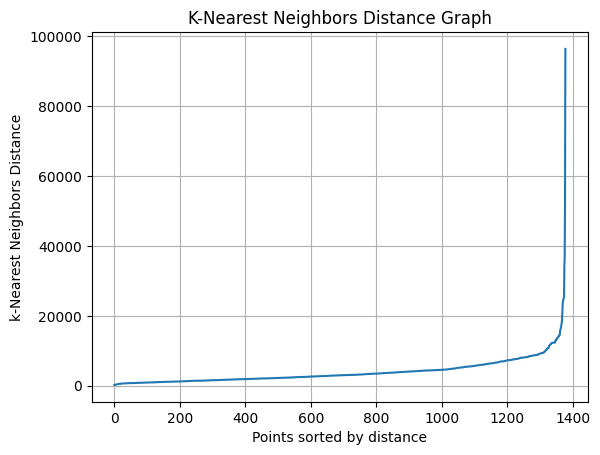

In [59]:
# 필요한 라이브러리를 임포트합니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from geopy.distance import great_circle
from sklearn.preprocessing import StandardScaler

# 위도와 경도 데이터를 불러옵니다.
coords = mapo_data[['위도', '경도']]

# 데이터 스케일링
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Haversine 거리를 계산하는 함수
def haversine_distance(x, y):
    return great_circle(x, y).meters

# NearestNeighbors 모델을 사용하여 k-거리 계산
minPts = 5 
nbrs = NearestNeighbors(n_neighbors=minPts, metric=haversine_distance).fit(coords_scaled)
distances, indices = nbrs.kneighbors(coords_scaled)

# k-거리를 정렬
sorted_distances = np.sort(distances, axis=0)
sorted_distances = sorted_distances[:,1]

# 키네스트 그래프 그리기
plt.plot(sorted_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('k-Nearest Neighbors Distance')
plt.title('K-Nearest Neighbors Distance Graph')
plt.grid(True)
plt.show()

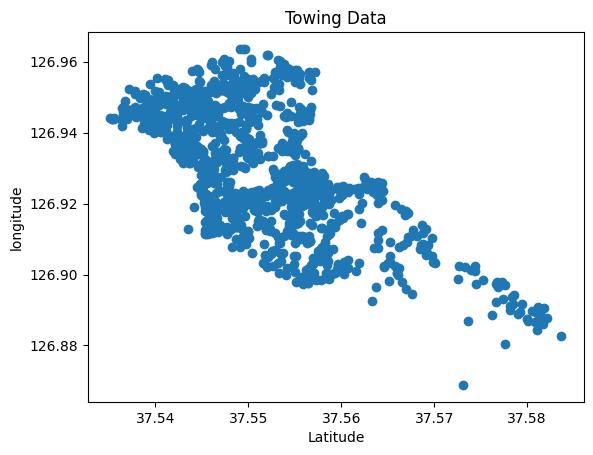

In [60]:
import matplotlib.pyplot as plt

# 데이터 생성
x = mapo_data['위도']
y = mapo_data['경도']

# 그래프 그리기
plt.scatter(x, y)

# 그래프 제목과 축 레이블 추가
plt.title('Towing Data')
plt.xlabel('Latitude')
plt.ylabel('longitude')

# 그래프 표시
plt.show()


#### Hpyeraparameter 결정 결론
계산된 `eps`값으로는 군집이 너무 커져서 우리의 데이터 분석에는 적절하지 않다. <br>
따라서 `시각적으로 접근`하여 군집의 간격이 자연스럽게 나오는 `eps` 값을 찾아서 분석을 진행하였다. <br>
또한 군집을 형성 할 수 있는 최소 샘플 개수는 10개로 설정하였다.

위도: 1도는 약 110.574 킬로미터<br>
경도: 1도는 적도에서 111.320 킬로미터지만, 위도에 따라 변함 (위도가 높아질수록 작아짐)<br>
eps가 0.001도인 경우, 위도에 따라 다소 차이가 있지만 대략적으로 다음과 같은 거리에 해당<br>

-> 위도에서 0.001도는 약 110.574m * 0.001 = 0.110574 킬로미터, 즉 약 111 미터

<hr>

In [61]:
import folium
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# 데이터 준비 (위도와 경도)
coordinates = mapo_data[['위도', '경도']].values

# DBSCAN 모델 생성 및 피팅
dbscan = DBSCAN(eps=0.001, min_samples=10).fit(coordinates)

# 군집 결과
labels = dbscan.labels_

# 중심점 계산
centroids = []
for label in np.unique(labels):
    if label != -1:  # -1은 이상치를 나타냄
        points_in_cluster = coordinates[labels == label]
        centroid = points_in_cluster.mean(axis=0)
        centroids.append(centroid)

# Folium 맵 초기화 (초기 위치는 첫 번째 데이터 포인트로 설정)
m = folium.Map(location=coordinates[0], zoom_start=16)

# 군집에 속한 위도, 경도를 지도에 표시
# 레이블에 따른 색상 매핑 생성
unique_labels = np.unique(labels[labels != -1])  # -1 (이상치) 제외
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# 군집에 속한 위도, 경도를 지도에 표시 (각 군집별로 다른 색상 사용)
for label, color in zip(unique_labels, colors):
    cluster_points = coordinates[labels == label]
    for point in cluster_points:
        folium.CircleMarker(
            location=point,
            radius=3,
            color=mcolors.to_hex(color),  # 컬러맵 색상을 HEX 형식으로 변환
            fill=True
        ).add_to(m)

# 군집의 중심점을 지도에 표시
for centroid in centroids:
    folium.Marker(
        location=centroid,
        icon=folium.Icon(color='green', icon='star')
    ).add_to(m)

# 지도 표시
m

In [62]:
# 원본 DataFrame에 군집 레이블을 추가
mapo_data['Cluster_Label'] = labels

# 새로운 DataFrame 생성
clustered_data = mapo_data[['위도', '경도', 'Cluster_Label']]

# 결과 출력
print(clustered_data)

             위도          경도  Cluster_Label
0     37.547761  126.922683             -1
1     37.549800  126.920306              0
2     37.549427  126.918705              0
3     37.553742  126.927136             -1
4     37.551166  126.923721             15
...         ...         ...            ...
1373  37.561921  126.924081             11
1374  37.540563  126.940209             -1
1375  37.545626  126.930206             27
1376  37.540149  126.942568              8
1377  37.543603  126.937327              5

[1378 rows x 3 columns]


-1번째 군집은 이상치를 의미한다.

In [63]:
mapo_data.groupby('Cluster_Label').count()

,신고일시,시군구명,주소,유형,위도,경도
Cluster_Label,,,,,,
-1,683,683,683,683,683,683
0,74,74,74,74,74,74
1,43,43,43,43,43,43
2,41,41,41,41,41,41
3,65,65,65,65,65,65
4,46,46,46,46,46,46
5,23,23,23,23,23,23
6,9,9,9,9,9,9
7,27,27,27,27,27,27


In [64]:
centroids

[array([ 37.54899385, 126.91976487]),
 array([ 37.5466793 , 126.95207972]),
 array([ 37.54683312, 126.91271822]),
 array([ 37.55663357, 126.92283137]),
 array([ 37.55586242, 126.92740194]),
 array([ 37.54296061, 126.93761039]),
 array([ 37.54452208, 126.94946919]),
 array([ 37.54296101, 126.95175487]),
 array([ 37.5394296 , 126.94491794]),
 array([ 37.55610846, 126.91009919]),
 array([ 37.55489064, 126.91567488]),
 array([ 37.56166165, 126.92462941]),
 array([ 37.55457436, 126.9354672 ]),
 array([ 37.54472115, 126.9352331 ]),
 array([ 37.55427259, 126.92214314]),
 array([ 37.55277628, 126.92415782]),
 array([ 37.5451302 , 126.94586424]),
 array([ 37.54581992, 126.92775735]),
 array([ 37.54793742, 126.942149  ]),
 array([ 37.54578151, 126.91885116]),
 array([ 37.54248983, 126.94700289]),
 array([ 37.54521807, 126.92548587]),
 array([ 37.54756716, 126.93245215]),
 array([ 37.55619966, 126.89840563]),
 array([ 37.55119634, 126.93727711]),
 array([ 37.54517505, 126.92260923]),
 array([ 37.

군집으로 설정될 수 있는 원 반경을 정하기 위해 중심점으로부터 가장 먼 점까지의 거리를 찾아 원을 그렸다.

In [65]:
from geopy.distance import great_circle

# 각 군집의 원 반경을 저장할 리스트
cluster_radii = []

for label in np.unique(labels):
    if label != -1:  # 노이즈 포인트 제외
        # 군집에 속한 모든 점
        cluster_points = coordinates[labels == label]
        # 군집의 중심점
        centroid = np.mean(cluster_points, axis=0)
        # 중심점에서 가장 먼 점까지의 거리를 찾음
        max_distance = max([great_circle(centroid, point).meters for point in cluster_points])
        cluster_radii.append(max_distance)

# 이제 cluster_radii 리스트에 각 군집의 최대 반경이 미터 단위로 저장되어 있음
# 이미 생성된 Folium 맵에 군집 반경을 그림
for (centroid, radius) in zip(centroids, cluster_radii):
    folium.Circle(
        location=centroid,
        radius=radius,
        # color='blue',
        fill=True,
        fill_opacity=0.5
    ).add_to(m)

m

In [66]:
parking_app = pd.read_excel('/kaggle/input/d/sanghyuni/seoul-public-kickboard-towing-data-and-parking-data/App_parking.xlsx')

In [67]:
parking_app

,시군구명,주소,위도,경도
0,마포구,마포대로 15,37.538625,126.943970
1,마포구,마포대로 19 신화빌딩,37.539010,126.944279
2,마포구,마포동,37.537130,126.943842
3,마포구,마포대로 25,37.539423,126.944797
4,마포구,마포대로 33,37.540040,126.945471
...,...,...,...,...
730,종로구,서울특별시 종로구 적선동 81-1,37.575760,126.973206
731,종로구,서울특별시 종로구 옥인6가길 62,37.579968,126.965098
732,종로구,서울특별시 종로구 옥인6길 19,37.581125,126.964668
733,종로구,서울특별시 종로구 율곡로2길 19,37.574166,126.981315


In [68]:
for n in parking_app.index:
    folium.CircleMarker([parking_app['위도'][n], parking_app['경도'][n]],radius = 5 , color = 'black').add_to(m)

m

In [69]:
public_parking = pd.read_excel('/kaggle/input/d/sanghyuni/seoul-public-kickboard-towing-data-and-parking-data/public_parking.xlsx')

In [70]:
for n in public_parking.index:
    folium.Marker([public_parking['위도'][n], public_parking['경도'][n]]).add_to(m)

m